In [2]:
import pandas as pd
from JigsawDataLoader import *
import torch
import torch.nn as nn
from torch import cat
import torch.nn.init as init
from torchvision.models.resnet import ResNet, BasicBlock
import matplotlib.pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
from PIL import Image
from itertools import permutations
perm = list(permutations([0,1,2,3]))

In [3]:
bs = 16
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

## patch size = 180

In [4]:
train_pth = pd.read_csv('../train.csv')
train_ds = DataLoader(train_pth, img_size=256, patch_size=180)
img_list = train_pth.values.reshape(-1).tolist()

In [5]:
def viz(index=90):
    orig = plt.imread(img_list[index])
    x = torch.cat(tuple(train_ds[index][0].squeeze()), 1)
    plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.imshow(orig, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(x[0], cmap='gray')

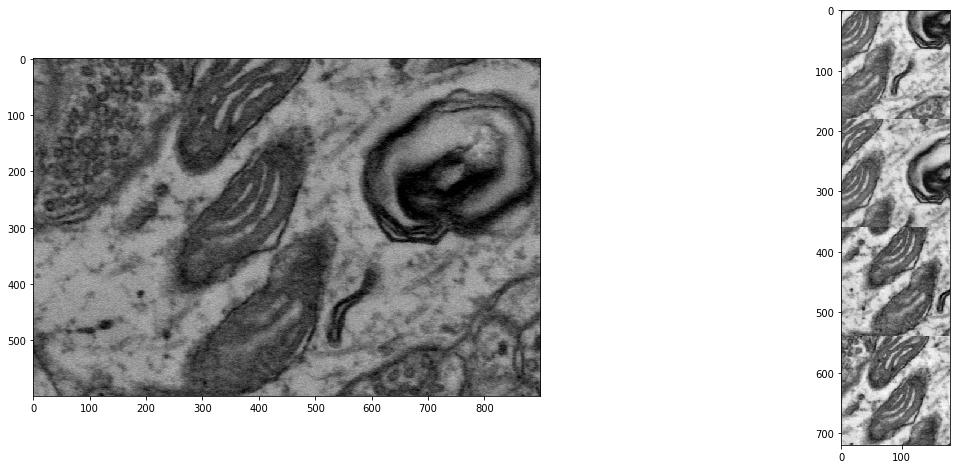

In [6]:
viz(24)

## AlexNet & ResNet based CFNs

In [9]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=24):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc6 = nn.Sequential(nn.Dropout(),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024*4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(4):
            z = self.features(x[i])
            z = self.avgpool(z)
            z = torch.flatten(z, 1)
            z = self.fc6(z)
            z = z.view([B,1,-1])
            x_list.append(z)
        x = torch.cat(x_list,1)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [7]:
class ResNet34(ResNet):
    
    def __init__(self, num_classes=24):
        super().__init__(block=BasicBlock, layers=[3, 4, 6, 3], num_classes=num_classes)
        self.fc = nn.Linear(512 * BasicBlock.expansion * 4, num_classes)
        
    def _forward_impl(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(4):
            z = x[i]
            z = self.conv1(z)
            z = self.bn1(z)
            z = self.relu(z)
            z = self.maxpool(z)

            z = self.layer1(z)
            z = self.layer2(z)
            z = self.layer3(z)
            z = self.layer4(z)
            z = self.avgpool(z)
            
            x_list.append(z)

        x = torch.cat(x_list, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

## Training

In [11]:
def subsample_dl(ds, bs=16, pct=0.1, seed=None):
    """Takes a DataLoader object as input and returns a mini-version of the dataset
    This is useful for debugging and rapid experimentation. 
    data -> a databunch object
    pct  -> the fraction of original dataset size (default: 0.1)"""
    import numpy as np
    if seed: np.random.seed(seed)
    size = len(ds)
    indices = np.random.choice(np.arange(size), 
                                   size=int(pct*size), replace=False)
    sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
    mini_dl = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=bs,
                                            sampler=sampler,
                                            num_workers=4)
    return mini_dl

In [12]:
train_data = subsample_dl(train_ds, bs)

### ResNet diverges

In [8]:
net = ResNet34()
net = net.cuda()

In [9]:
# loss func and optimizer
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay = 1e-3)

In [13]:
batch_time, net_time = [], []
for epoch in range(10):
#         if epoch%10==0 and epoch>0:
#             test(net,criterion,logger_test,val_loader,steps)
#         lr = adjust_learning_rate(optimizer, epoch, init_lr=args.lr, step=20, decay=0.1)
        net.train()
        total_loss = 0
        total_items = 0
        for i, (images, labels) in enumerate(progress_bar(train_data)):
            images = images.cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(input=outputs, target=labels)
            print(loss)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()*len(labels)
            total_items += len(labels)
        train_loss = total_loss / total_items
        print(f'Train loss {train_loss:.2f}')

tensor(3.8419, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.5309, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.0953, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(2.7324, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.2699, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.2792, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.2272, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.0933, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(4.4088, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(4.1256, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.8317, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.6106, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(5.3128, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(5.0065, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(4.5934, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(nan, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(nan, device='cuda:2', grad_fn=<NllLossBackward>)
ten

KeyboardInterrupt: 

### AlexNet plateaus

In [22]:
net = AlexNet()
net = net.cuda()

In [23]:
# loss func and optimizer
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay = 1e-3)

In [24]:
batch_time, net_time = [], []
for epoch in range(10):
#         if epoch%10==0 and epoch>0:
#             test(net,criterion,logger_test,val_loader,steps)
#         lr = adjust_learning_rate(optimizer, epoch, init_lr=args.lr, step=20, decay=0.1)
        net.train()
        total_loss = 0
        total_items = 0
        for i, (images, labels) in enumerate(progress_bar(train_data)):
            images = images.cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(input=outputs, target=labels)
            print(loss)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()*len(labels)
            total_items += len(labels)
        train_loss = total_loss / total_items
        print(f'Train loss {train_loss:.2f}')

tensor(3.1790, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1804, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1789, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1818, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1733, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1783, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1783, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1753, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1796, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1802, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1795, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1819, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1787, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1771, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1773, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1764, device='cuda:2', grad_fn=<NllLossBackward>)
tensor(3.1760, device='cuda:2', grad_fn=<NllLossBackward

KeyboardInterrupt: 